In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Input, SeparableConv2D, concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.utils import np_utils

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

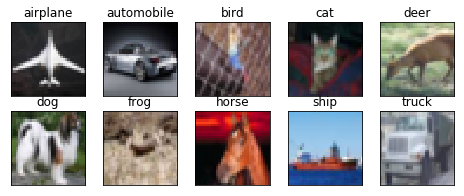

In [47]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Functional API

In [51]:
                                                                        

#INPUT LAYER
inputs = Input(shape=(32, 32, 3))
x1 = Conv2D(128, 3, 3, border_mode='same')(inputs)                      
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Dropout(0.1)(x1)

# Spatial Separable Convolution
x2 = Conv2D(128, 3, 1, border_mode='same')(x1)                          
x2 = Conv2D(256, 1, 3, border_mode='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = Dropout(0.1)(x2)

#TRANSITION LAYER
x3 = MaxPooling2D(pool_size=(2, 2))(x2)                                 
x3 = Conv2D(64, (1, 1))(x3)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)

# Depthwise Separable Convolution
x4 = SeparableConv2D(128, 3, 3, border_mode='same')(x3)                 
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = Dropout(0.1)(x4)
x5 = SeparableConv2D(128, 3, 3, border_mode='same')(x3)                 
x5 = BatchNormalization()(x5)
x5 = Activation('relu')(x5)
x5 = Dropout(0.1)(x5)

#TRANSITION LAYER
x6_1 = MaxPooling2D(pool_size=(2, 2))(x4)                                    
x6_1 = Conv2D(64, (1, 1))(x6_1)
x6_1 = BatchNormalization()(x6_1)
x6_2 = MaxPooling2D(pool_size=(2, 2))(x5)                                    
x6_2 = Conv2D(64, (1, 1))(x6_2)
x6_2 = BatchNormalization()(x6_2)

# Group Convolution
x7 = Conv2D(128, 3, 3, border_mode='same',dilation_rate=1)(x6_1)             
x7 = BatchNormalization()(x7)
x7 = Activation('relu')(x7)
x7 = Dropout(0.1)(x7)
x8 = Conv2D(128, 3, 3, border_mode='same',dilation_rate=2)(x6_2)             
x8 = BatchNormalization()(x8)
x8 = Activation('relu')(x8)
x8 = Dropout(0.1)(x8)
merge = concatenate([x7, x8])

#OUTPUT LAYER
x9 = Conv2D(10, 1, activation='relu')(merge)                                  
x9 = Conv2D(10, 8)(x9)
x9 = Flatten()(x9)
predictions = Activation('softmax')(x9)
model = Model(inputs=inputs, outputs=predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 1), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API

In [52]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 32, 32, 128)  3584        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_35 (BatchNo (None, 32, 32, 128)  512         conv2d_42[0][0]                  
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 32, 32, 128)  0           batch_normalization_35[0][0]     
__________________________________________________________________________________________________
dropout_27

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:348: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
391/391 [==============================] - 50s 127ms/step - loss: 1.3262 - acc: 0.5214 - val_loss: 1.1460 - val_acc: 0.6020
Epoch 2/50
391/391 [==============================] - 45s 115ms/step - loss: 0.8978 - acc: 0.6820 - val_loss: 0.8491 - val_acc: 0.7037
Epoch 3/50
391/391 [==============================] - 45s 116ms/step - loss: 0.7366 - acc: 0.7422 - val_loss: 0.7625 - val_acc: 0.7342
Epoch 4/50
391/391 [==============================] - 45s 116ms/step - loss: 0.6472 - acc: 0.7733 - val_loss: 0.7918 - val_acc: 0.7288
Epoch 5/50
391/391 [==============================] - 45s 116ms/step - loss: 0.5860 - acc: 0.7939 - val_loss: 0.7194 - val_acc: 0.7484
Epoch 6/50
391/391 [==============================] - 45s 115ms/step - loss: 0.5254 - acc: 0.8171 - val_loss: 0.6921 - val_acc: 0.7640
Epoch 7/50
391/391 [==============================] - 45s 116ms/step - loss: 0.4781 - acc: 0.8318 - val_loss: 0.6713 - val_acc: 0.7722
Epoch 8/50
391/391 [==============================] - 4

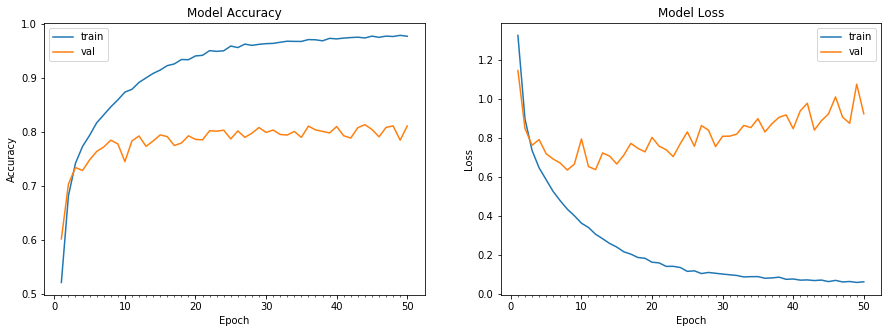

Accuracy on test data is: 29.67


In [54]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=True)
datagen.fit(train_features)
training_set= datagen.flow(train_features, train_labels, batch_size=128)
test_set= datagen.flow(test_features, test_labels, batch_size=128)

# train the model
start = time.time()
# Train the model

model_info = model.fit_generator(training_set, steps_per_epoch=len(training_set), epochs=50, validation_data = test_set, validation_steps = len(test_set))

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))